Epoch 1/50


/Users/conquerorbala/miniconda3/envs/anlpa1/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0471
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0471
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123 - val_loss: 0.0470
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0476
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0157 - val_loss: 0.0469
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143 - val_loss: 0.0469
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0120 - val_loss: 0.0468
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0112 - val_loss: 0.0468
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0159 - val_loss: 0.0469
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0468
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - val_loss: 0.0472
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0134 - val_loss: 0.0466


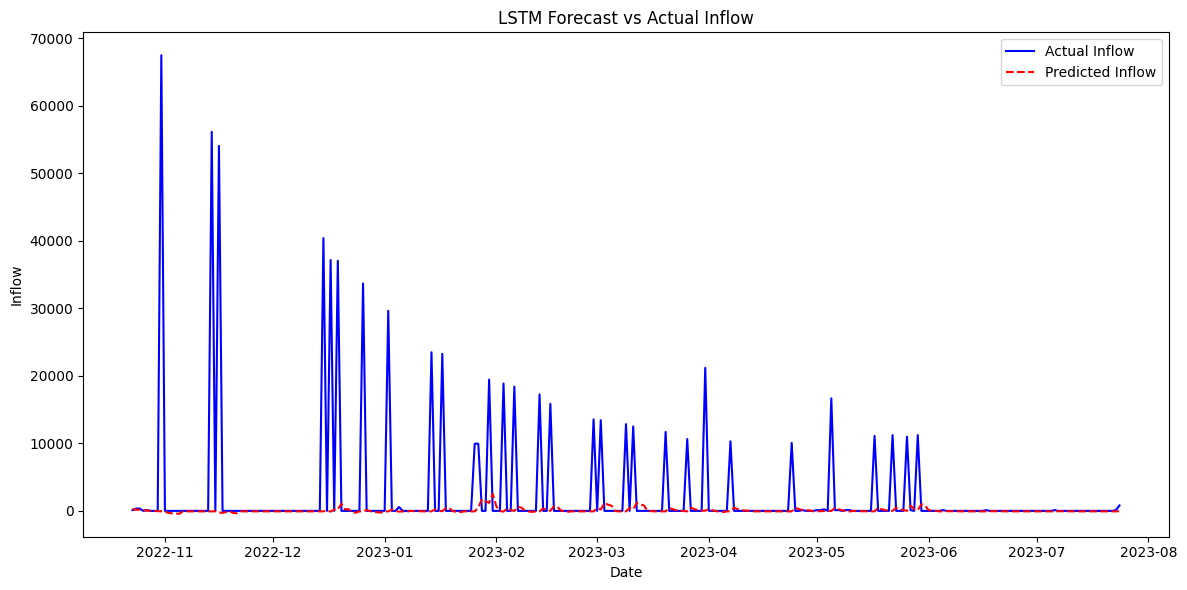

Mean Absolute Error (MAE): 2670.8186722650757
Comparison between actual and predicted values:
        Date      Actual   Predicted
0 2022-10-23  115.740741  301.250183
1 2022-10-24  347.222222  163.197586
2 2022-10-25  347.222222  169.302246
3 2022-10-26    0.000000  134.613770
4 2022-10-27  115.740741   30.013348


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def forecast_and_evaluate_lstm(train_file, val_file, test_file, look_back=5):
    # Load the data
    df_train = pd.read_csv(train_file, parse_dates=['date'])
    df_val = pd.read_csv(val_file, parse_dates=['date'])
    df_test = pd.read_csv(test_file, parse_dates=['date'])

    # Combine train and validation sets
    df_train_val = pd.concat([df_train, df_val], ignore_index=True)

    # Sort the data by date
    df_train_val = df_train_val.sort_values('date').reset_index(drop=True)
    df_test = df_test.sort_values('date').reset_index(drop=True)

    # Set 'date' as the index
    df_train_val.set_index('date', inplace=True)
    df_test.set_index('date', inplace=True)

    # Extract the 'inflow' values
    train_val_values = df_train_val['inflow'].values
    test_values = df_test['inflow'].values

    # Feature Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_val_scaled = scaler.fit_transform(train_val_values.reshape(-1, 1))
    test_scaled = scaler.transform(test_values.reshape(-1, 1))

    # Function to create sequences
    def create_sequences(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back, 0])
            y.append(data[i + look_back, 0])
        return np.array(X), np.array(y)

    # Create sequences for training
    X_train, y_train = create_sequences(train_val_scaled, look_back)

    # Create sequences for testing
    total_data = np.concatenate((train_val_scaled[-look_back:], test_scaled), axis=0)
    X_test, y_test = create_sequences(total_data, look_back)

    # Reshape input to [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

    # Make predictions on the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform predictions and actual values
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Prepare the forecast dataframe
    forecast_dates = df_test.index[:len(y_pred)]
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Actual': y_test_actual.flatten(),
        'Predicted': y_pred.flatten()
    })

    # Evaluate performance using Mean Absolute Error (MAE)
    mae = mean_absolute_error(forecast_df['Actual'], forecast_df['Predicted'])

    # Plot the forecast vs actual values
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_df['Date'], forecast_df['Actual'], label='Actual Inflow', color='blue')
    plt.plot(forecast_df['Date'], forecast_df['Predicted'], label='Predicted Inflow', color='red', linestyle='--')
    plt.title('LSTM Forecast vs Actual Inflow')
    plt.xlabel('Date')
    plt.ylabel('Inflow')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return forecast results and MAE
    return forecast_df, mae

# Paths to your CSV files
train_file = 'train.csv'  # Path to your train.csv
val_file = 'val.csv'      # Path to your val.csv
test_file = 'test.csv'    # Path to your test.csv

# Call the function to forecast and evaluate performance
forecast_results, mae = forecast_and_evaluate_lstm(train_file, val_file, test_file)

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print("Comparison between actual and predicted values:")
print(forecast_results.head())
